# TP4 :  Learning on a low budget
**Théo Rudkiewicz, Cyriaque Rousselot**

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data samples are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ exists but is not accessible. 
(To make your task easier, we provide you with some data (named `test_dataset` in the code) that you can use to test your model, but you **must not** use it to train your model).

We also assume that we have a limited computational budget.

The goal of this practical session is to guide you through different methods that will help you get better results from few resources (data & compute).

In this practical, we will use the `resnet18` architecture. We will use models from the [pytorch vision hub ](https://pytorch.org/vision/stable/models.html#).

# QUESTIONS

## Grading

You will be graded on 5 questions. You will need to provide 7 files : 
1. This Notebook
2. `utils.py`
3. `last_layer_finetune.pth` (the file **must be of size less than 5Mo**)
4. `daug_resnet.pth` (the file **must be of size less than 50Mo**)
5. `final_model.pth` (the file **must be of size less than 50Mo**)
6. `drawing_lora.png`
7. `cutmix.png`

If the code you defined passes all our tests, you will get the full grade. Otherwise we  will look at the intermediate questions in the notebook to give you partial credit.



 Please provide clear and short answers between `<div class="alert alert-info">  <your answer>  </div>` tags (when it's not code).  

<div class="alert alert-info">  Example of answer  </div>

In [1]:
import os

if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("data/TP4_images"):
    os.mkdir("data/TP4_images")
    !cd data/TP4_images && wget -O north_dataset_train.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/yzQRWE2YjmFn9WA/download/north_dataset_train.zip" && unzip north_dataset_train.zip
    !cd data/TP4_images && wget -O north_dataset_test.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/zntidWrFdYsGMDm/download/north_dataset_test.zip" && unzip north_dataset_test.zip
dir_path = "data/TP4_images/"

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms, models
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from peft import LoraConfig, get_peft_model
from copy import deepcopy
# you can install torchmetrics with `pip install torchmetrics`


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


north_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_sample",
    transform=transforms.Compose([transforms.ToTensor()]),
)
test_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_test",
    transform=transforms.Compose([transforms.ToTensor()]),
)
base_model = models.resnet18()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

## Question 1 : 
>  Change the last layer of the resnet model so that its size fits the problem. 

In [5]:
# Hint 
print(base_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
base_model.fc = nn.Linear(base_model.fc.in_features, 2)

In [7]:
assert (
    base_model.fc.out_features == 2
)  # we could also change the last layer to have 1 output. Do it with 2 so that it matches our tests procedure during grading.

## Question 2: 
> Train the last layer of a randomly initialized resnet model. Provide a function precompute_features in `utils.py` that creates a new dataset from the features precomputed by the model.

Intermediate question :  Provide the training process in the notebook with training curve. Comment on the accuracy. 

In [8]:
def precompute_features(
    model: models.ResNet, 
    dataset: torch.utils.data.Dataset, 
    device: torch.device
) -> torch.utils.data.Dataset:
    """
    Create a new dataset with the features precomputed by the model.

    Arguments:
    ----------
    model: models.ResNet
        The model used to precompute the features
    dataset: torch.utils.data.Dataset
        The dataset to precompute the features from
    device: torch.device
        The device to use for computation
    
    Returns:
    --------
    torch.utils.data.Dataset
        A new dataset with precomputed features
    """
    model = model.to(device)
    model.eval()

    features_list = []
    labels_list = []

    def hook(module, input, output):
        features_list.append(output.flatten(start_dim=1).cpu())

    layer = model.avgpool  # For resnet avgpool is the last layer before fc, can be different for other models
    hook_handle = layer.register_forward_hook(hook)

    with torch.no_grad():
        for i in range(len(dataset)):
            x, y = dataset[i]
            x = x.unsqueeze(0).to(device)
            labels_list.append(y)
            model(x)

    hook_handle.remove()

    features_tensor = torch.cat(features_list, dim=0)
    labels_tensor = torch.tensor(labels_list)

    return TensorDataset(features_tensor, labels_tensor)

In [9]:
from utils import precompute_features

train_features_untrained_weights = precompute_features(base_model, north_dataset, device)
test_features_untrained_weights = precompute_features(base_model, test_dataset, device)

In [10]:
def train_last_layer(model, train_dataset, test_dataset, device=device):
    epochs = 20000
    lr = 1e-3
    batch_size = 8
    
    train_losses = []
    test_accuracies = []
    eval_epochs = []

    best_accuracy = 0
    best_model = model
    
    model = model.to(device)
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in tqdm(range(1, epochs+1)):
        model.train()
        total_loss = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            y_pred = model.fc(x)
            
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device).long()

                y_pred = model.fc(x)
                predicted = torch.argmax(y_pred, dim=1)
                correct += (predicted == y).sum().item()
                total += y.size(0)

        accuracy = correct / total
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = deepcopy(model)
        
        if epoch % 1000 == 0:
            eval_epochs.append(epoch)
            test_accuracies.append(accuracy)
            print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    return best_model, best_accuracy, {'train_losses': train_losses, 'test_accuracies': test_accuracies, 'eval_epochs': eval_epochs}

In [3]:
def plot_training_curve(metrics):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    ax1.plot(range(1, len(metrics['train_losses'])+1), metrics['train_losses'], label='Training Loss')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss over Epochs')
    ax1.grid(True)
    
    ax2.plot(metrics['eval_epochs'], metrics['test_accuracies'], 'o-', label='Test Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Test Accuracy over Epochs')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [4]:
def load_model(path):
    model = models.resnet18()
    model.fc = nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load(path))
    return model

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1000/20000, Loss: 0.3522, Accuracy: 0.5000
Epoch 2000/20000, Loss: 0.2502, Accuracy: 0.5476
Epoch 3000/20000, Loss: 0.1947, Accuracy: 0.5714
Epoch 4000/20000, Loss: 0.1406, Accuracy: 0.5714
Epoch 5000/20000, Loss: 0.0993, Accuracy: 0.5714
Epoch 6000/20000, Loss: 0.0703, Accuracy: 0.5952
Epoch 7000/20000, Loss: 0.0539, Accuracy: 0.6190
Epoch 8000/20000, Loss: 0.0463, Accuracy: 0.6429
Epoch 9000/20000, Loss: 0.0401, Accuracy: 0.5952
Epoch 10000/20000, Loss: 0.0280, Accuracy: 0.5952
Epoch 11000/20000, Loss: 0.0173, Accuracy: 0.6429
Epoch 12000/20000, Loss: 0.0146, Accuracy: 0.6429
Epoch 13000/20000, Loss: 0.0105, Accuracy: 0.5952
Epoch 14000/20000, Loss: 0.0091, Accuracy: 0.6429
Epoch 15000/20000, Loss: 0.0082, Accuracy: 0.5952
Epoch 16000/20000, Loss: 0.0049, Accuracy: 0.6429
Epoch 17000/20000, Loss: 0.0036, Accuracy: 0.6429
Epoch 18000/20000, Loss: 0.0028, Accuracy: 0.6667
Epoch 19000/20000, Loss: 0.0023, Accuracy: 0.6429
Epoch 20000/20000, Loss: 0.0016, Accuracy: 0.6429
Best mode

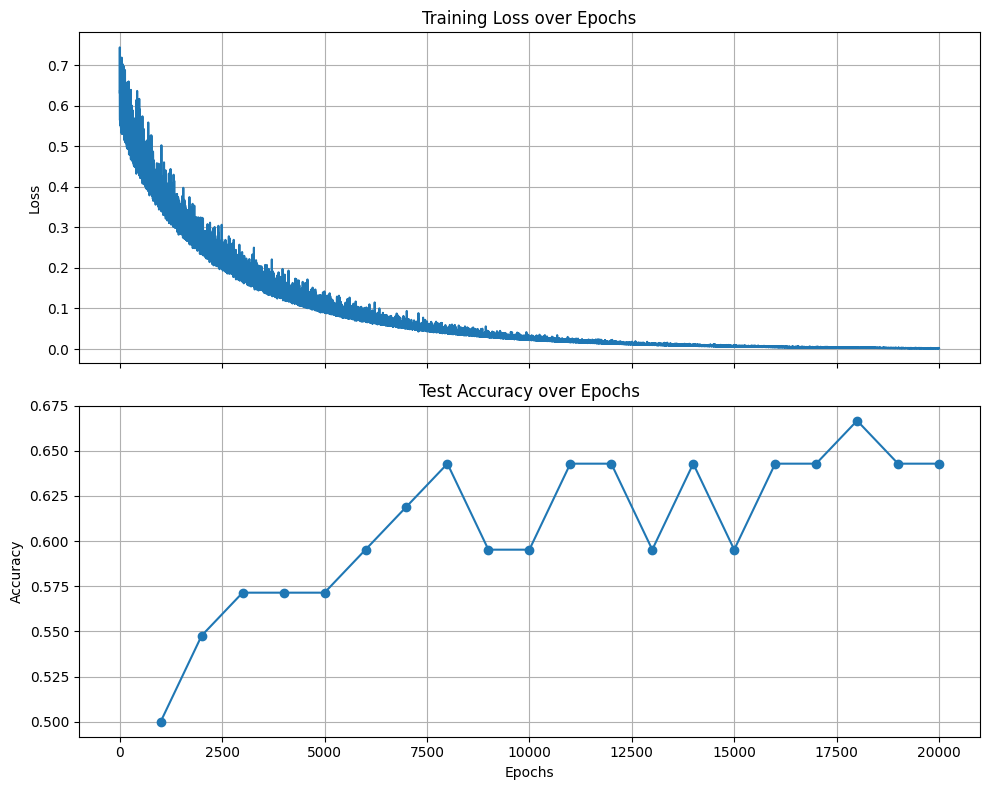

In [12]:
best_model_untrained, best_model_untrained_accuracy, metrics_untrained = train_last_layer(base_model, train_features_untrained_weights, test_features_untrained_weights, "cpu")
print(f"Best model accuracy: {best_model_untrained_accuracy:.4f}")
plot_training_curve(metrics_untrained)

<div class="alert alert-info">
The training curves show a gradually decreasing loss (in our case from 0.7 to almost 0) over the 20,000 epochs, which indicates that the model is learning from the data and continuously improving its predictions. The test accuracy remains at 50% (equivalent to randomly guessing) for the first 1,000 epochs, then starts to gradually improve while struggling to reach an accuracy of over 70%. The limited accurarcy underlines the problems that can arise when only training the final layer on features from a randomly initialized network with a small dataset.
</div>

## Question 3 : 
> Now start from a pretained model on Imagenet (https://pytorch.org/vision/stable/models.html#) and only train the last layer. Provide the training process in the notebook with training curve. 

 Provide two files : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a file  `utils.py` containing only the last layer class `LastLayer` inheriting from `torch.nn.Module` architecture of your final model to load
 -  a `last_layer_finetune.pth` file containing __only the last layer weights__ (we will check the size) 
 
 We will test your model on final accuracy on a test set. 
 

In [13]:
pretrained_model = models.resnet18(weights="DEFAULT")
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, 2)

In [14]:
from utils import precompute_features

train_features_trained_weights = precompute_features(pretrained_model, north_dataset, device)
test_features_trained_weights = precompute_features(pretrained_model, test_dataset, device)

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1000/20000, Loss: 0.0002, Accuracy: 0.7857
Epoch 2000/20000, Loss: 0.0000, Accuracy: 0.7857
Epoch 3000/20000, Loss: 0.0000, Accuracy: 0.8095
Epoch 4000/20000, Loss: 0.0000, Accuracy: 0.8095
Epoch 5000/20000, Loss: 0.0000, Accuracy: 0.8095
Epoch 6000/20000, Loss: 0.0000, Accuracy: 0.8095
Epoch 7000/20000, Loss: 0.0000, Accuracy: 0.8095
Epoch 8000/20000, Loss: 0.0000, Accuracy: 0.8095
Epoch 9000/20000, Loss: 0.0000, Accuracy: 0.8095
Epoch 10000/20000, Loss: 0.0000, Accuracy: 0.8095
Epoch 11000/20000, Loss: 0.0000, Accuracy: 0.8095
Epoch 12000/20000, Loss: 0.0000, Accuracy: 0.8095
Epoch 13000/20000, Loss: 0.0000, Accuracy: 0.8095
Epoch 14000/20000, Loss: 0.0000, Accuracy: 0.8095
Epoch 15000/20000, Loss: 0.0000, Accuracy: 0.8095
Epoch 16000/20000, Loss: 0.0000, Accuracy: 0.8095
Epoch 17000/20000, Loss: 0.0000, Accuracy: 0.8095
Epoch 18000/20000, Loss: 0.0000, Accuracy: 0.8095
Epoch 19000/20000, Loss: 0.0000, Accuracy: 0.8095
Epoch 20000/20000, Loss: 0.0000, Accuracy: 0.8095
Best mode

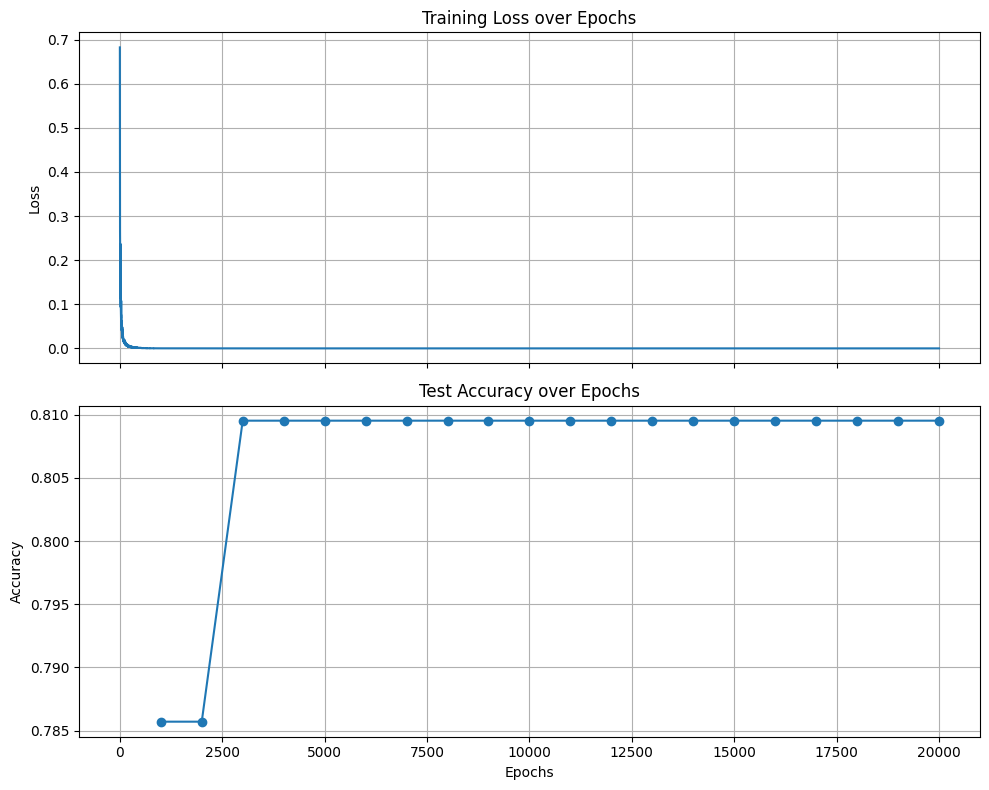

In [15]:
best_model_pretrained, best_model_pretrained_accuracy, metrics_pretrained = train_last_layer(pretrained_model, train_features_trained_weights, test_features_trained_weights, "cpu")
print(f"Best model accuracy: {best_model_pretrained_accuracy:.4f}")
plot_training_curve(metrics_pretrained)

In [16]:
torch.save(best_model_pretrained.fc.state_dict(), "last_layer_finetune.pth")

In [17]:
from utils import LastLayer

resnet = models.resnet18(weights="DEFAULT")
fc = LastLayer()  # !  Important : No argument
fc.load_state_dict(torch.load("last_layer_finetune.pth", weights_only=True))
resnet.fc = fc
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<div class="alert alert-info">
The training curves show a sharp drop of the training loss from 0.8 to 0 within the first 1,000 epochs, which indicates that the model rapidly learns from the data and reaches a local optimum in terms of performance. As far as the test accuracy is concerned, the model is able to predict at a higher accuracy from the start, hinting towards the efficiency of using pretrained weights. The transfer learning from ImageNet does occur, providing sufficiently informative features for the classification layer. We can see that the accuracy plateaus at a value of about 80%, suggesting that it could still be of interest to explore other finetuning methods to further improve the model's performance.
</div>

## Question 4 : 
> Perform  LoRA https://arxiv.org/pdf/2106.09685  on the model  (We are perfectly fine if you use an external library **for this question only**, and of course use it in the next questions). (Warning : without data augmentation it may not improve the accuracy.)

Intermediate question : Describe LoRA. There are different ways of implementing LoRa for convolutions. You can choose your preferred one. Explain the version of LoRa you used, provide a drawing of the process in the `drawing_lora.png` file. (Hint: you can obtain a small rank convolution by combining a convolution and a 1x1 convolution. One of the two goes from a higher number of channels to a lower number of channels and the other one restores the number of channels.)

<div class="alert alert-info">
For convolutional layers, LoRA adapts the original low-rank adaptation approach to handle the 4D tensor structure of convolution weights. Unlike traditional LoRA for linear layers which uses matrices A and B to create a low-rank decomposition, the convolutional version uses a two-step process where input features first pass through a smaller convolution A that projects from C_in channels to a much lower rank r, followed by a 1×1 convolution B that projects back to C_out channels.
<br><br>
This efficient parameterization creates a path parallel to the frozen pretrained weights, with the final output combining both paths as h = W*x + a(B*A*x), where a is a scaling factor (set to 32 in our implementation). By setting r (16 in our implementation) significantly smaller than both C_in and C_out, this approach dramatically reduces the number of trainable parameters while still providing sufficient expressivity to adapt the model to new tasks or domains, making fine-tuning both memory-efficient and computationally feasible.
</div>

In [18]:
lora_model = models.resnet18(weights="DEFAULT")
lora_model.fc = nn.Linear(lora_model.fc.in_features, 2)

In [5]:
def train_lora(model, train_dataset, test_dataset, device=device):
    epochs = 1000
    lr = 1e-4
    batch_size = 8

    train_losses = []
    test_accuracies = []
    eval_epochs = []
    best_accuracy = 0
    best_lora_model = model

    conv_layers = []
    for name, module in base_model.named_modules():
        if isinstance(module, nn.Conv2d) and "conv" in name:
            conv_layers.append(name)

    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        target_modules=conv_layers,
        lora_dropout=0.1,
        bias="none"        
    )

    lora_model = get_peft_model(model, lora_config).to(device)
    optimizer = torch.optim.Adam(lora_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    for name, param in lora_model.named_parameters():
        if "lora" not in name:
            param.requires_grad = False
    
    for epoch in tqdm(range(1, epochs+1)):
        lora_model.train()
        total_loss = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            y_pred = lora_model(x)
            
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        lora_model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device).long()

                y_pred = lora_model(x)
                predicted = torch.argmax(y_pred, dim=1)
                correct += (predicted == y).sum().item()
                total += y.size(0)

        accuracy = correct / total
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_lora_model = deepcopy(lora_model)

        if epoch % 100 == 0:
            eval_epochs.append(epoch)
            test_accuracies.append(accuracy)
            print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    return best_lora_model, best_accuracy, {'train_losses': train_losses, 'test_accuracies': test_accuracies, 'eval_epochs': eval_epochs}

'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100/1000, Loss: 0.1881, Accuracy: 0.8095
Epoch 200/1000, Loss: 0.0159, Accuracy: 0.7857
Epoch 300/1000, Loss: 0.0020, Accuracy: 0.7857
Epoch 400/1000, Loss: 0.0273, Accuracy: 0.8571
Epoch 500/1000, Loss: 0.3706, Accuracy: 0.8333
Epoch 600/1000, Loss: 0.0055, Accuracy: 0.8333
Epoch 700/1000, Loss: 0.0045, Accuracy: 0.8333
Epoch 800/1000, Loss: 0.0083, Accuracy: 0.8571
Epoch 900/1000, Loss: 0.0055, Accuracy: 0.8571
Epoch 1000/1000, Loss: 0.0067, Accuracy: 0.8571
Best model accuracy: 0.9048


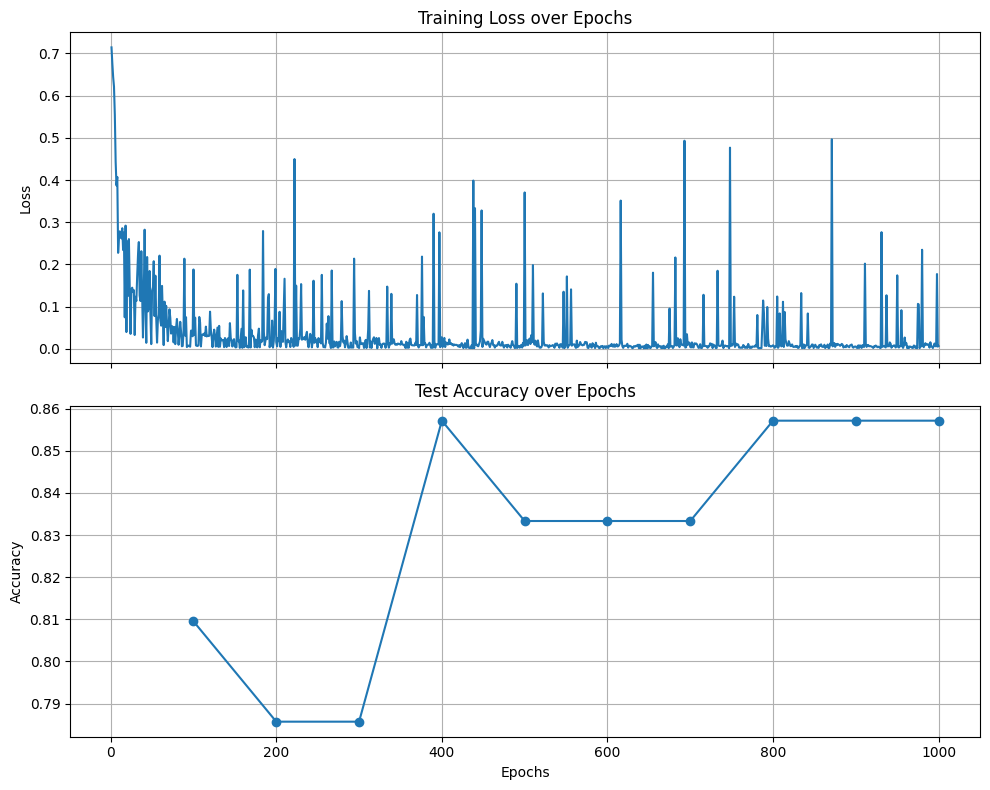

In [20]:
best_model_lora, best_model_lora_accuracy, metrics_lora = train_lora(lora_model, north_dataset, test_dataset)
print(f"Best model accuracy: {best_model_lora_accuracy:.4f}")
plot_training_curve(metrics_lora)

In [50]:
merged_weights = best_model_lora.merge_and_unload()
final_resnet = models.resnet18()
final_resnet.fc = nn.Linear(final_resnet.fc.in_features, 2)
final_resnet.load_state_dict(merged_weights.state_dict())
final_resnet = final_resnet.to("cpu")
torch.save(final_resnet.state_dict(), "lora_resnet.pth")

<div class="alert alert-info">
The training curves show a relatively noisy loss over the course of the 20,000 epochs. Although the general trend tends to be decreasing, some clear spikes are visable throughout the training phase, suggesting that the model has encountered difficult batches or has made too large weight updates. Overall, we can see that the LoRA finetuned model performs better than resnet with the default weights, suggesting that LoRA finetuning can lead to better results. Nevertheless, the accuracy seems to be upper bounded by around 90%, a value which could possibly be attained through additional techniques such as data augmentation.
</div>

## Question 5 : 
In order to better train our LORA weights, let's do some Data Augmentation https://en.wikipedia.org/wiki/Data_augmentation . Load some alteration of the data from the `torchvision.transforms` module and incorporate them in your training pipeline.

 Intermediate question : Check CutMix  (https://pytorch.org/vision/stable/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py) and explain it with a small drawing `cutmix.png`. 


  Provide one file : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a `daug_resnet.pth` file containing the weight of the ResNet18 after DAUG  (!  It  has to be of the class ResNet so you have to merge LoRA weights with the ResNet18 weights)

<div class="alert alert-info">
The idea of cutmix is to create new (image, label) samples through the combination of labelled samples. In other words, this is achieved by switching parts of the original images through rectangular cuts (can be of any given size). As a result, the multiclass labels of the obtained images are generally the area ratio of images from that class.
</div>

In [7]:
## Data Augmentation
from torchvision.transforms import v2

In [5]:
lora_model = models.resnet18(weights="DEFAULT")
lora_model.fc = nn.Linear(lora_model.fc.in_features, 2)

In [21]:
transform = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

augmented_north_dataset = datasets.ImageFolder(dir_path + "north_dataset_sample", transform=transform)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100/1000, Loss: 0.1156, Accuracy: 0.7619
Epoch 200/1000, Loss: 0.0887, Accuracy: 0.8333
Epoch 300/1000, Loss: 0.0719, Accuracy: 0.6905
Epoch 400/1000, Loss: 0.0132, Accuracy: 0.7857
Epoch 500/1000, Loss: 0.0822, Accuracy: 0.6667
Epoch 600/1000, Loss: 0.0496, Accuracy: 0.8333
Epoch 700/1000, Loss: 0.4821, Accuracy: 0.6429
Epoch 800/1000, Loss: 0.0270, Accuracy: 0.8095
Epoch 900/1000, Loss: 0.0248, Accuracy: 0.6905
Epoch 1000/1000, Loss: 0.0286, Accuracy: 0.8095
Best model accuracy: 0.9286


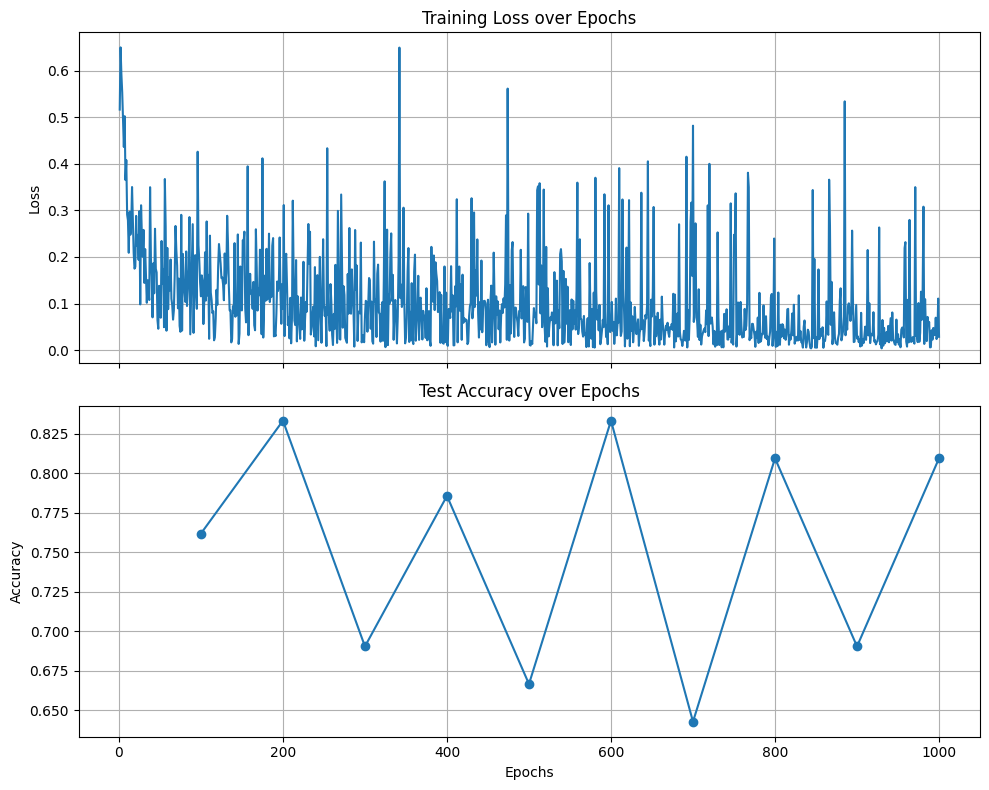

In [22]:
best_model_lora_augmented, best_model_lora_augmented_accuracy, metrics_lora_augmented = train_lora(lora_model, augmented_north_dataset, test_dataset)
print(f"Best model accuracy: {best_model_lora_augmented_accuracy:.4f}")
plot_training_curve(metrics_lora_augmented)

In [11]:
merged_weights = best_model_lora_augmented.merge_and_unload()
final_resnet = models.resnet18()
final_resnet.fc = nn.Linear(final_resnet.fc.in_features, 2)
final_resnet.load_state_dict(merged_weights.state_dict())
final_resnet = final_resnet.to("cpu")
torch.save(final_resnet.state_dict(), "daug_resnet.pth")

In [12]:
lora_model = load_model("daug_resnet.pth")
assert isinstance(lora_model, models.ResNet)

/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_26012/298715746.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<div class="alert alert-info">
Similar to the training curves in the previous question, we can observe that the loss tends to be decreasing over time, however, the training phase seems to lack stability. While the best performing model reaches a similar accuracy as in the non augmented case, one could possibly conclude that data augmentation doesn't improve performance in our setting due to the lack of consistency during training.
</div>

## Question 6 : (BONUS) 
> Do the best you can : improve performance on test set while keeping ResNet 18 architecture, or decrease the size of the model

Provide a file  `final_model.pth` containing the weights of the final model and provide the class `FinalModel()` in the `utils.py` file. 